In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD 
from sklearn.preprocessing import normalize 


from sklearn import metrics
import nltk
import os
from nltk.corpus import stopwords
from textblob import Word
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
nltk.download("stopwords")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mandi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [38]:
df = pd.read_csv("newtest.CSV")
df

c:\Users\mandi\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Subject,Body,From: (Name),From: (Address),From: (Type),To: (Name),To: (Address),To: (Type),CC: (Name),CC: (Address),...,Unnamed: 108,Unnamed: 109,Unnamed: 110,Unnamed: 111,Unnamed: 112,Unnamed: 113,Unnamed: 114,Unnamed: 115,Unnamed: 116,Unnamed: 117
0,SUTDReviews --- Sharing reviews on SUTD Mods,Hey SUTDFam!!\r\n\r\n \r\n\r\nHaving trouble d...,Student Government - Media & Marketing,/O=EXCHANGELABS/OU=EXCHANGE ADMINISTRATIVE GRO...,EX,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Re: Request for Interview for Pedagogical Project,"Hi Sarah,\r\n\r\nThanks for responding. The on...",Keegan Kang,/O=EXCHANGELABS/OU=EXCHANGE ADMINISTRATIVE GRO...,EX,"Student - Chua Yi Qi, Sarah;Tan Da Yang",/o=ExchangeLabs/ou=Exchange Administrative Gro...,EX;EX,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Change of Name for the ISTD Degree Programme,"Dear Students,\r\n\r\n \r\n\r\nSUTD will be ch...",Tony Quek,/O=EXCHANGELABS/OU=EXCHANGE ADMINISTRATIVE GRO...,EX,*All Students,/o=ExchangeLabs/ou=Exchange Administrative Gro...,EX,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Fw: 88 Call for Stories,\r\n\r\n________________________________\r\n\r...,Sumbul Khan,/O=EXCHANGELABS/OU=EXCHANGE ADMINISTRATIVE GRO...,EX,"Student - Chua Yi Qi, Sarah;Student - Ong Lok Hen",/o=ExchangeLabs/ou=Exchange Administrative Gro...,EX;EX,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Revised Student Exco and Cohort Advisor prog...,"Dear Student Reps,\r\n\r\n \r\n\r\nThank you f...",Lim Bee Foong,/O=EXCHANGELABS/OU=EXCHANGE ADMINISTRATIVE GRO...,EX,NaN,NaN,NaN,Lin Wuzhong;Lim Bee Foong,/o=ExchangeLabs/ou=Exchange Administrative Gro...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48443,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48445,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
df['Body'] = df['Body'].astype(str)
df['Body'] = df['Body'].apply(lambda x: x.lower())
punctuations = '\.\!\?'
df = (df.drop('Body',axis=1).merge(df.Body.str.extractall(f'(?P<Body>[^{punctuations}]+[{punctuations}])\s?').reset_index('match'),left_index=True, right_index=True, how='left'))
df['Body'] = df['Body'].str.replace("[^\w\s<>]", "")
df = df.replace(r'[^0-9a-zA-Z ]', '', regex=True).replace("'", '')
#print(type(df['Body']))
#df.applymap(type)
df['Body'] = df['Body'].astype(str)
df['Body'] = df['Body'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()])) # change similar terms to the same
stop = stopwords.words("english") #remove useless words
df['Body'] = df['Body'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

df

,Subject,From: (Name),From: (Address),From: (Type),To: (Name),To: (Address),To: (Type),CC: (Name),CC: (Address),CC: (Type),...,Unnamed: 110,Unnamed: 111,Unnamed: 112,Unnamed: 113,Unnamed: 114,Unnamed: 115,Unnamed: 116,Unnamed: 117,match,Body
0,SUTDReviews Sharing reviews on SUTD Mods,Student Government Media Marketing,OEXCHANGELABSOUEXCHANGE ADMINISTRATIVE GROUP F...,EX,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,hey sutdfam
0,SUTDReviews Sharing reviews on SUTD Mods,Student Government Media Marketing,OEXCHANGELABSOUEXCHANGE ADMINISTRATIVE GROUP F...,EX,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,trouble deciding mod take
0,SUTDReviews Sharing reviews on SUTD Mods,Student Government Media Marketing,OEXCHANGELABSOUEXCHANGE ADMINISTRATIVE GROUP F...,EX,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,want find taken
0,SUTDReviews Sharing reviews on SUTD Mods,Student Government Media Marketing,OEXCHANGELABSOUEXCHANGE ADMINISTRATIVE GROUP F...,EX,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,fret
0,SUTDReviews Sharing reviews on SUTD Mods,Student Government Media Marketing,OEXCHANGELABSOUEXCHANGE ADMINISTRATIVE GROUP F...,EX,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,sutd senior came together create sutdreviews h...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
48443,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
48444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
48445,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan


In [40]:
#vect = TfidfVectorizer(stop_words='english', max_df=0.50, min_df=2)

# max_df removes words that appears more than _%
# min_df removes words that appears less than _

vect = TfidfVectorizer(ngram_range=(1,3),
                     min_df = 10,
                     max_df = 0.4,
                     token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*[a-z]+\\w*\\b')
X = vect.fit_transform(df['Body'].values.astype('U'))

In [41]:
# Kmeans
from sklearn.cluster import KMeans
n_clusters = 6
# clf = KMeans(n_clusters=n_clusters, max_iter=300, init='k-means++', n_init=1)
# labels = clf.fit_predict(X)

# For larger datasets use mini-batch KMeans, so we dont have to read all data into memory.
batch_size = 500
clf = MiniBatchKMeans(n_clusters=n_clusters, init_size=1000, batch_size=batch_size, max_iter=100)  
clf.fit(X)

# Let's plot this with matplotlib to visualize it.
# First we need to make 2D coordinates from the sparse matrix.
X_dense = X.todense()
pca = PCA(n_components=2).fit(X_dense)
coords = pca.transform(X_dense)

# Lets plot it again, but this time we add some color to it.
# This array needs to be at least the length of the n_clusters.
label_colors = ["#2AB0E9", "#2BAF74", "#D7665E", "#CCCCCC", 
                "#D2CA0D", "#522A64", "#A3DB05", "#FC6514"]
colors = [label_colors[i] for i in labels]
# Plot clusters
plt.scatter(coords[:, 0], coords[:, 1], c=colors)





MemoryError: Unable to allocate 39.1 GiB for an array with shape (245676, 21373) and data type float64

In [ ]:
# top keywords in the emails

def top_tfidf_feats(row, features, top_n=20000):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats, columns=['features', 'score'])
    return df
def top_feats_in_doc(X, features, row_id, top_n=25):
    row = np.squeeze(X[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

features = vect.get_feature_names()
print(top_feats_in_doc(X, features, 1, 10))

                   features     score
0                     break  0.562185
1                     month  0.520911
2                      good  0.465901
3                      hope  0.442195
4  zoom meetinghttpssutdedu  0.000000
5          first come first  0.000000
6                    flight  0.000000
7                  flexible  0.000000
8                      flat  0.000000
9                  flagship  0.000000


In [ ]:
# top terms out of all the emails
def top_mean_feats(X, features, grp_ids=None, min_tfidf=0.1, top_n=20000):
    if grp_ids:
        D = X[grp_ids].toarray()
    else:
        D = X.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

print(top_mean_feats(X, features, top_n=10))

            features     score
0                edu  0.079715
1               sutd  0.073126
2                com  0.061127
3         protection  0.059396
4            outlook  0.059377
5          safelinks  0.059348
6         httpsapc01  0.032114
7  urlhttps3a2f2fwww  0.016099
8             office  0.009853
9          instagram  0.009263


In [ ]:
# extracts the top terms per cluster
features = vect.get_feature_names()
def top_feats_per_cluster(X, y, features, min_tfidf=0.1, top_n=10):
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label) 
        feats_df = top_mean_feats(X, features, ids,    min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

top_feats_per_cluster(X, labels, features, min_tfidf=0.1, top_n=10)

[            features     score
 0                com  0.077344
 1         protection  0.075154
 2            outlook  0.075130
 3         httpsapc01  0.040554
 4  urlhttps3a2f2fwww  0.020370
 5             office  0.012467
 6          instagram  0.011720
 7               zoom  0.010260
 8               team  0.010148
 9                 sg  0.009334,
                    features     score
 0                      sutd  0.999602
 1                httpsapc01  0.000892
 2  zoom meetinghttpssutdedu  0.000000
 3                first come  0.000000
 4                    flight  0.000000
 5                  flexible  0.000000
 6                      flat  0.000000
 7                  flagship  0.000000
 8                      five  0.000000
 9                first time  0.000000,
                    features  score
 0                       edu    1.0
 1  zoom meetinghttpssutdedu    0.0
 2                first come    0.0
 3                    flight    0.0
 4                  flexible    0.0
 

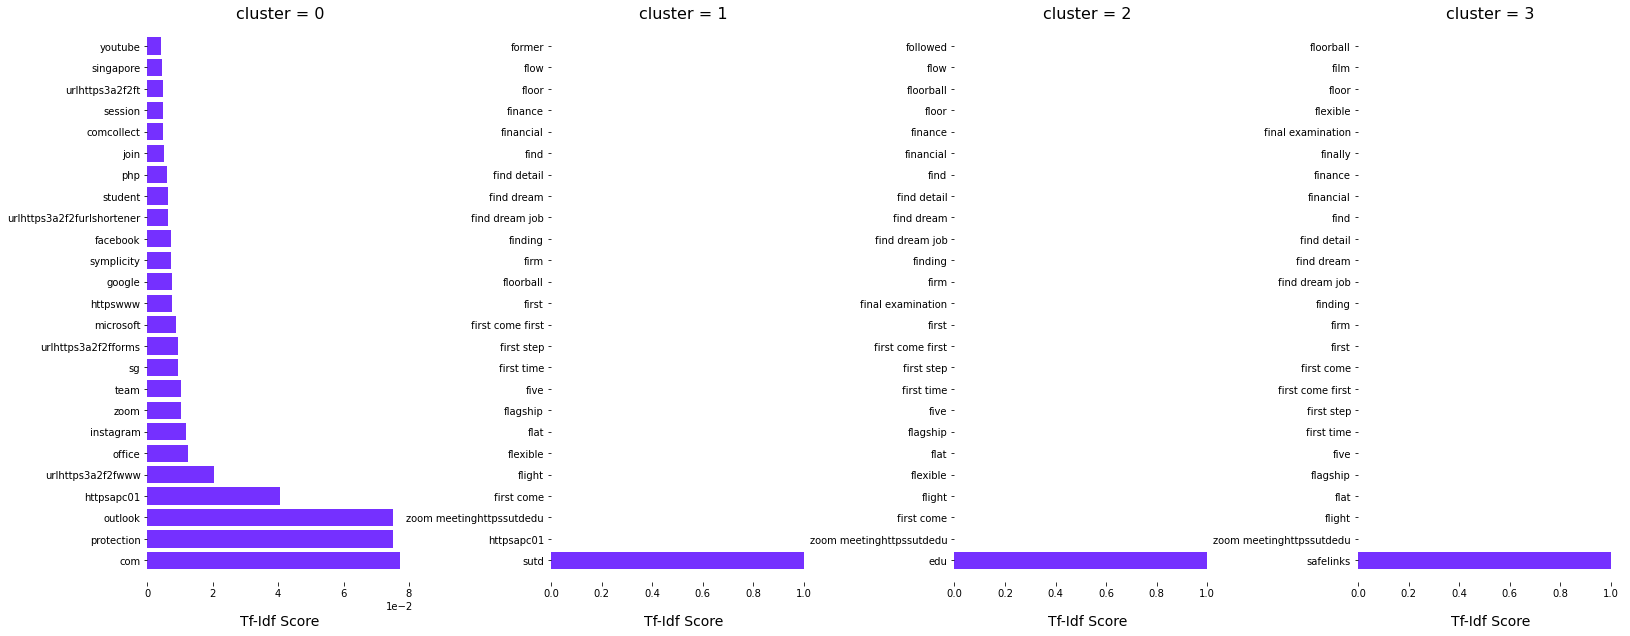

In [ ]:
#Use this to print the top terms per cluster with matplotlib.

def plot_tfidf_classfeats_h(dfs):
    fig = plt.figure(figsize=(25, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("cluster = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.score, align='center', color='#7530FF')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.features)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()


plot_tfidf_classfeats_h(top_feats_per_cluster(X, labels, features, 0.1, 25))

In [ ]:
# km = KMeans(n_clusters=5).fit(df)

# cluster_map = pd.DataFrame()
# cluster_map['data_index'] = df.index.values
# cluster_map['cluster'] = clf.labels_

# cluster_map[cluster_map.cluster == 2]
#df.loc[df.ID == 103, 'FirstName'] = "Matt"
#df.loc[df[clf.labels_==0], 'Meetings'] = df.Categories 
#df.loc = df[clf.labels_==0]['Categories'].fillna('Meeting')
#df['Categories'][mask] = "Meeting"
#df.loc[df[clf.labels_==0], 'Categories'] = 'Meeting'
df['Classifications'] = pd.Series(labels, index=df.index)
df_new = df[df['Classifications'] != 1]
df_new

X = df['Body']
y = pd.to_numeric(df['Classifications'])
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=101)

In [ ]:
# count every word/phrase and put it into a matrix
vect = TfidfVectorizer(ngram_range=(1,3),
                     min_df = 5,
                     max_df = 0.4,
                     token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*[a-z]+\\w*\\b')
vect.fit(X_train)
X_train_dtm = vect.transform(X_train)
X_test_dtm = vect.transform(X_test)

In [ ]:
# converting sparse matrices into dense matrices
# replace empty spaces in the matrices with 0 (some sentences might not have a specific word)
X_train_dense = pd.DataFrame(X_train_dtm.toarray(), columns = vect.get_feature_names())
X_test_dense = pd.DataFrame(X_test_dtm.toarray(), columns = vect.get_feature_names())
pca = PCA()
X_train_pca = pca.fit_transform(X_train_dense)
X_test_pca = pca.transform(X_test_dense)

In [ ]:
pca = PCA(n_components = 250) # put a reasonable number from graph (70%-90%)
X_train_pca = pca.fit_transform(X_train_dense)
X_test_pca = pca.transform(X_test_dense)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=200, criterion="entropy", n_jobs=-1, random_state=0)
rfc.fit(X_train_pca, y_train)
predictions = rfc.predict(X_test_pca)
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

[[7029    0    0    0]
 [   1  582    0    0]
 [   0    0  777    0]
 [   0    0    0  479]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7029
           1       1.00      1.00      1.00       583
           2       1.00      1.00      1.00       777
           3       1.00      1.00      1.00       479

    accuracy                           1.00      8868
   macro avg       1.00      1.00      1.00      8868
weighted avg       1.00      1.00      1.00      8868



In [ ]:
cm1 = confusion_matrix(y_test, predictions)
print("Confusion Matrix : \n", cm1)
total1 = sum(sum(cm1))

accuracy1 = (cm1[0,0] + cm1[1,1])/total1
print("Accuracy :", accuracy1)

sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print("Sensitivity :", sensitivity1)

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print("Specificity :", specificity1)

Confusion Matrix : 
 [[7029    0    0    0]
 [   1  582    0    0]
 [   0    0  777    0]
 [   0    0    0  479]]
Accuracy : 0.8582543978349121
Sensitivity : 1.0
Specificity : 0.9982847341337907


In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(10,5),max_iter=500)
mlp.fit(X_train_pca,y_train)
y_pred_class = mlp.predict(X_test_pca)
print(y_pred_class)

[0 0 0 ... 0 1 0]
